<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/Brace_angles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

 angleModel1/      dataset_pytorch.py        labels                  test_subset.pkl
 annotations/      figures/                  lstm_model2.pth         timeDistModel/
 bracedataset.py   head_floor.PNG            lstm_model.pth          train_subset.pkl
 brace_test.pkl    hip_knee_ankle.PNG       'MODELS ACCURACY.gdoc'   utils/
 brace_test.pth    hip_knee_horizontal.PNG   names                   videos_info.csv
 brace_train.pkl   keras_model/              path/                   wrists_floor.PNG
 brace_train.pth   keypoints_angles.py       __pycache__/
 dataClips         k_model_features/         README.md
 dataset/          k_model_features2/        tensor_dataset.pkl


In [10]:
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.1 MB/s eta 0:00:00


In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [5]:
# #only import to get funtion names
# import inspect
# import keypoints_angles
# function_list = [o for o in dir(keypoints_angles) if inspect.isfunction(getattr(keypoints_angles, o))]
# print(function_list)

In [43]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

#angles
from keypoints_angles import body_parts, calculate_angle, calculate_angle_to_horizontal, calculate_hand_to_floor_distance, calculate_head_position
from keypoints_angles import calculate_head_to_floor_distance, calculate_leg_angles, calculate_mean_angles, calculate_mean_distance
from keypoints_angles import calculate_mean_hand_distance, calculate_mean_leg_angles, extract_angles_from_dataset, extract_hand_to_floor_distances
from keypoints_angles import  extract_head_to_floor_distances, extract_horizontal_angles_from_df, plot_hand_distance_3x2_with_category_names
from keypoints_angles import plot_head_to_floor_histograms, plot_hip_knee_floor, plot_hip_leg_angle

#CNN models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.models import Model
#dimensionality reduction and clustering
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder

Load Dataset


In [ ]:
# @title
###### Run to obtain the dataset, this takes a long time after the dataset can be access by loading the saved DataClips, Labels, Segments, sequences.
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# #get max length of the keypoints
# max_length = max(seq.shape[0] for seq in dataClips)

# #pad tensor so they are of the same lenght
# dataClips_tensors=[np.pad(array.astype(np.float32), ((0, max_length - array.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=0) for array in dataClips]
# dataClips_tensors=torch.tensor(dataClips_tensors)
# #convert labels to tensors
# label_tensors = np.array(encoded_categories)
# label_tensors=torch.tensor(label_tensors)
# ##SPLIT SET FOR REPRODUCTIVITY
# dataset = TensorDataset(dataClips_tensors, label_tensors)
# # Set seed for reproducibility
# torch.manual_seed(42)

# # Determine split sizes
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(f"Training set size: {len(train_dataset)}")
# print(f"Testing set size: {len(test_dataset)}")
# # Save the TensorDataset
# with open('tensor_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

# # Save the Subset
# with open('train_subset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)
# with open('test_subset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

In [16]:
#load segment
segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# Load the TensorDataset
with open('dataClips', 'rb') as f:
    dataClips = pickle.load(f)

# Load the training Subset
with open('labels', 'rb') as f:
    labels = pickle.load(f)

# Load the testing Subset
with open('names', 'rb') as f:
    names = pickle.load(f)

#encode labels from 0-2
unique_categories = list(set(labels))
category_to_int = {category: index for index, category in enumerate(unique_categories)}
encoded_categories = [category_to_int[category] for category in labels]
#get flatted clips
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

In [17]:
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']

# Dimensionality Reduction
The dataset contains 1352 clips with segments ranging from 105-1200 eah segment contains a 17X2 numpy. We will be conducting dimensionallty reduction to visualize our data.

In [18]:
dtw_means=[]
for i in dataClips:
    data=i
    data_flattened = [clip.reshape(clip.shape[0], -1) for clip in data]
    distance_matrix = dtw.distance_matrix_fast(data_flattened)
    mean_dist=distance_matrix.mean()
    dtw_means.append(mean_dist)

cluster_df=features[['seq_idx', 'frames']].copy()
cluster_df['dtw']= pd.Series(dtw_means)
cluster_df.shape

(1352, 3)

# Clustering with dynamic Time Warping.
https://en.wikipedia.org/wiki/Dynamic_time_warping.
"In time series analysis, dynamic time warping (DTW) is an algorithm for measuring similarity between two temporal sequences, which may vary in speed. For instance, similarities in walking could be detected using DTW, even if one person was walking faster than the other, or if there were accelerations and decelerations during the course of an observation. DTW has been applied to temporal sequences of video, audio, and graphics data"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


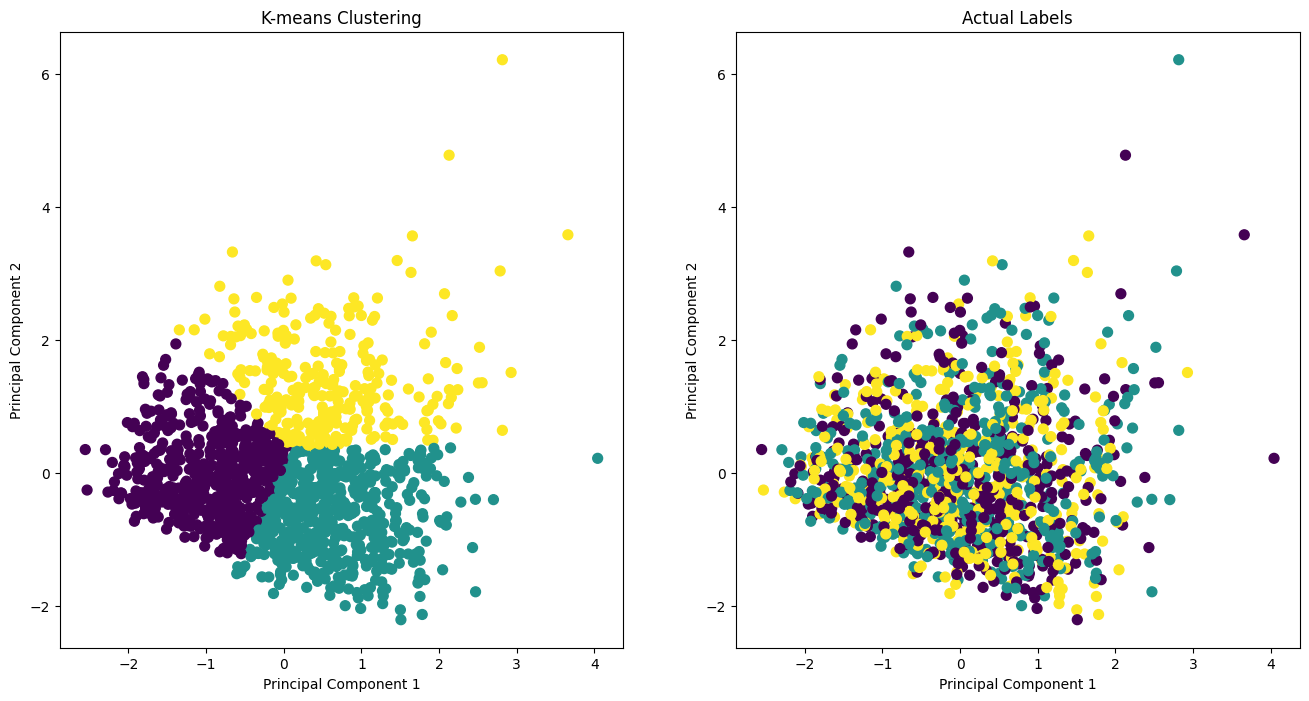

In [21]:
#PCA dimensionality reduction of dataClips processed with dynamic time warping.
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(cluster_df)
pca = PCA(n_components=2)
clusters_pca = pca.fit_transform(clusters_scaled)
pca_df = pd.DataFrame(data=clusters_pca, columns=['Principal Component 1', 'Principal Component 2'])

#K-means
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['ActualLabels'] = encoded_categories

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means Cluster Plot
ax[0].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax[0].set_title('K-means Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Actual Labels Plot
ax[1].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['ActualLabels'], cmap='viridis', s=50)
ax[1].set_title('Actual Labels')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.show()

Clustering does not perform very well, since we are not able to accurate separate the different labels.

In [22]:
category_to_int

{'powermove': 0, 'toprock': 1, 'footwork': 2}

# Perform Analysis with CNN-LSTM.
The CNN Long Short-Term Memory Network or CNN LSTM for short is an LSTM architecture specifically designed for sequence prediction problems with spatial inputs, like images or videos.

# Perform Analysis with CNN-LSTM
The CNN Long Short-Term Memory Network or CNN LSTM for short is an LSTM architecture specifically designed for sequence prediction problems with spatial inputs, like images or videos. We will try to predict the following movements.
Toprock-      Powermove- Footwork
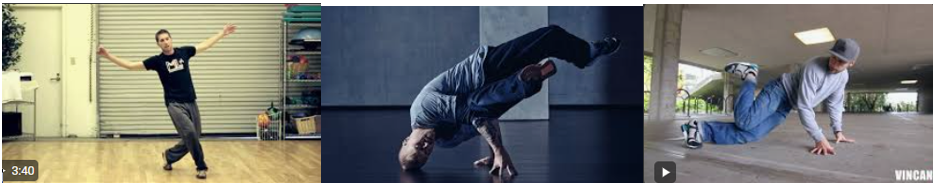

In [23]:
### LSTM MODEL WITH dense and drop out
padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 25s 779ms/step - loss: 1.0987 - accuracy: 0.3044 - val_loss: 1.1000 - val_accuracy: 0.2949
Epoch 2/1

In [24]:
# test
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 1s 131ms/step - loss: 1.0983 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


Model accuracy is too low, We will try Time distributed NN anoted model to handle video, time series data

In [27]:
####### Time Distributed CNN
#train test set
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

input_shape = (padded_clips.shape[1], 17, 2, 1)

model = Sequential([
    TimeDistributed(Conv1D(32, kernel_size=3, activation='relu'), input_shape=(1280, 34, 1)),
    TimeDistributed(MaxPooling1D(pool_size=2)),
    TimeDistributed(Flatten()),

    LSTM(50),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')

])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 1280, 32, 32)      128       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 1280, 16, 32)      0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 1280, 512)         0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 50)                112600    
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                      

In [28]:
# test
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 13s 1s/step - loss: 1.0989 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


Accuracy continues to be too low. We will see if adjusting the padding on the images will improve accuracy. Below we plotted the sequence lenght to determine the 90th percentile lenght.

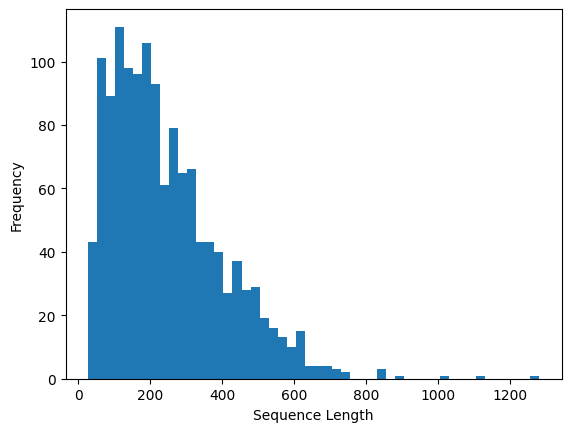

In [30]:
sequence_lengths = [len(seq) for seq in flattened_clips]

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maxlen based on the distribution, for example, the 90th percentile
maxlen = np.percentile(sequence_lengths, 90)

Based on that we pad the images only to the 90th percentile lenght truncating clips longer than that at the begining of the clip. We will try again with the LSTM model first

In [31]:
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=8, batch_size=32, validation_split=0.2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                17000     
                                                                 
 dense_4 (Dense)             (None, 100)               5100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
27/27 [==============================] - 7s 183ms/step - loss: 1.0991 - accuracy: 0.3588 - val_loss: 1.0442 - val_accuracy: 0.5023
Epoch 2/8

In [32]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test_onehot)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 1s 116ms/step - loss: 0.5819 - accuracy: 0.7196
Test accuracy: 0.7195571660995483


We observe a large improvement on accuracy

9/9 [==============================] - 2s 108ms/step
              precision    recall  f1-score   support

           0       0.62      0.98      0.76        98
           1       0.87      0.99      0.92        98
           2       0.67      0.03      0.05        75

    accuracy                           0.72       271
   macro avg       0.72      0.67      0.58       271
weighted avg       0.72      0.72      0.62       271



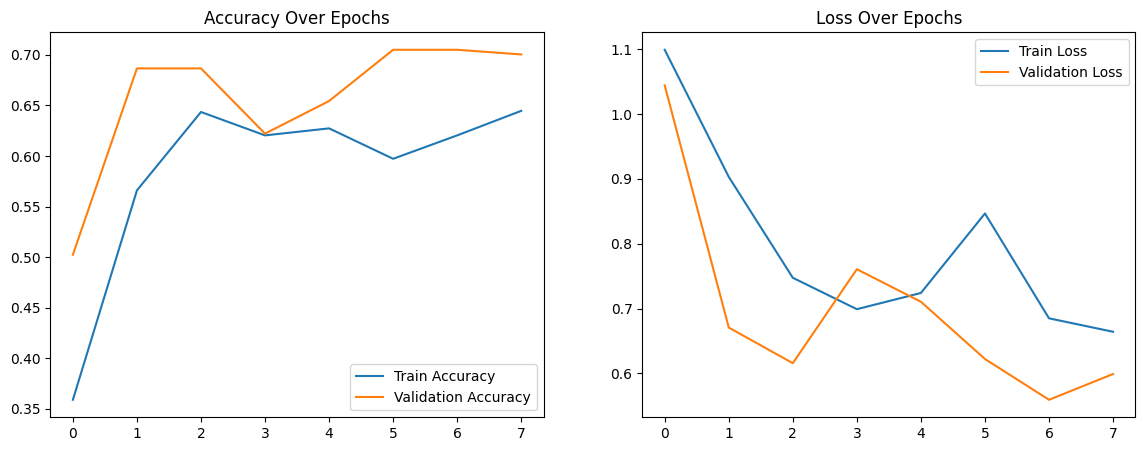

In [33]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix or use seaborn for a nicer plot

# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

# We will try to augment out data by introducing additional features.
In addition to the key points per each clip, we will include the sequence index and number of frames. This model requires to process keypoint and additional in to separate branches and combine the classifications weights. We will be using am LSTM model, since it is 10X faster to train that Time Distributed model, and we obtained similar results when training with keypoint only

In [38]:
##Prepocess additional features to augment our model
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('frames', OneHotEncoder(), ['frames'])
    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'frames']])
features_preprocessed = features_preprocessed.toarray()

In [46]:
padded_clips = pad_sequences(flattened_clips, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32')

X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50)(keypoint_input)
keypoint_model = Dense(100, activation='relu')(keypoint_model)

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu')(additional_features_input)

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()
history = model.fit([X_train_clips, X_train_features], y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 471, 34)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_6 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 505)]                0         []                            
 )                                                                                                
                                                                                            

In [48]:
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 98ms/step - loss: 0.4130 - accuracy: 0.8450
Test Loss: 0.41301509737968445
Test Accuracy: 0.8450184464454651


9/9 [==============================] - 2s 75ms/step
              precision    recall  f1-score   support

           0       0.73      0.93      0.82        98
           1       0.99      0.99      0.99        98
           2       0.84      0.55      0.66        75

    accuracy                           0.85       271
   macro avg       0.85      0.82      0.82       271
weighted avg       0.85      0.85      0.84       271



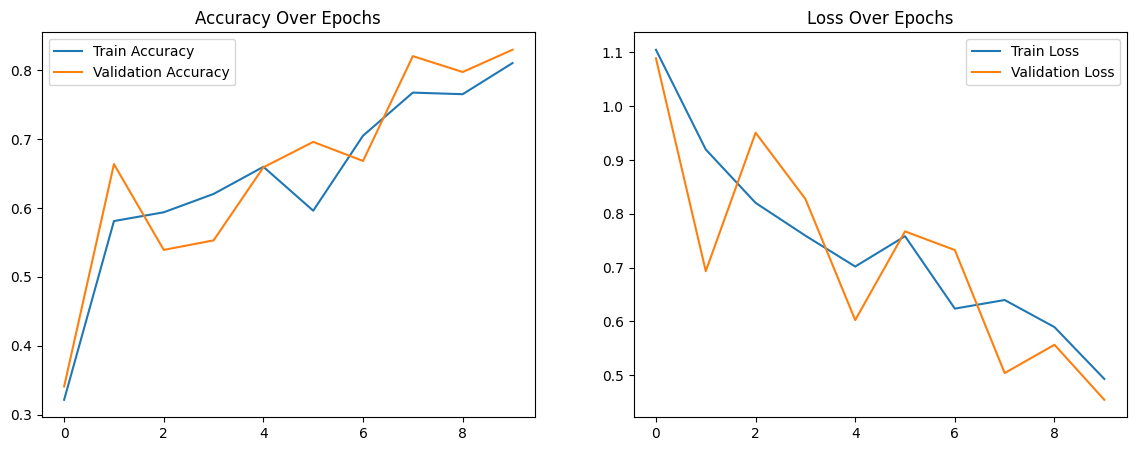

In [49]:
# Predictions
y_pred = model.predict([X_test_clips, X_test_features])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix or use seaborn for a nicer plot

# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

By introducing sequence number and the number of frames we obtain an 12% increase increase on accuracy. Next we will experiment with other features extraction in order to improve our results.

# Calculate Keypoint angles
We will experiment calculating different angles and distances between body parts in order to generate features that can improve our model.

In [ ]:
df_body_parts = pd.DataFrame(list(body_parts().keys()), index=body_parts().values(), columns=['bodyParts'])
df_body_parts

,bodyParts
0,Nose
1,Left Eye
2,Right Eye
3,Left Ear
4,Right Ear
5,Left Shoulder
6,Right Shoulder
7,Left Elbow
8,Right Elbow
9,Left Wrist


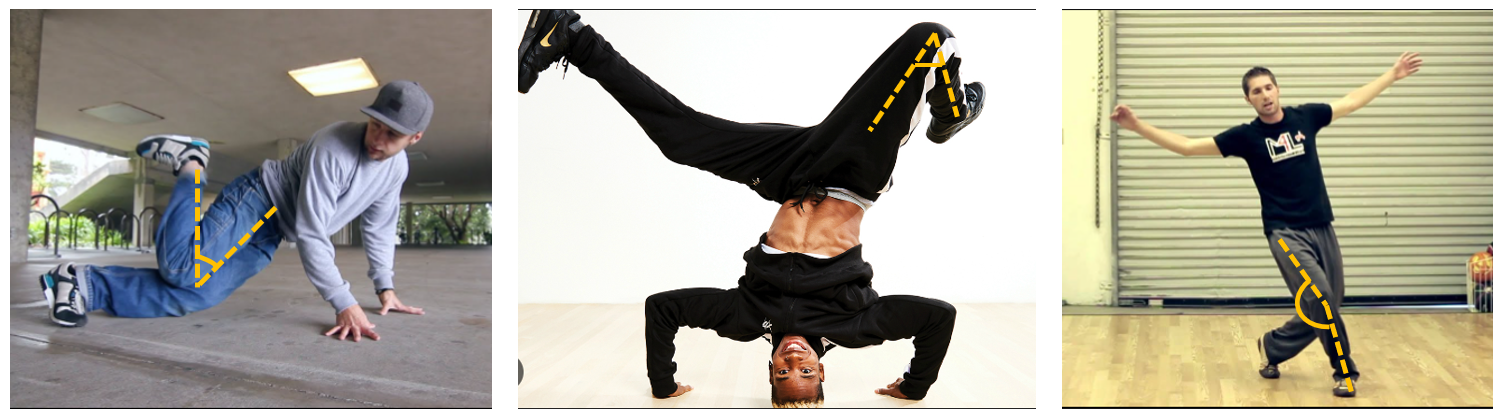

In [ ]:
# Keypoint indices for right and left legs
right_keypoints = [12, 14, 16]
left_keypoints = [11, 13, 15]
category_to_int= {'toprock': 0, 'powermove': 1, 'footwork': 2}

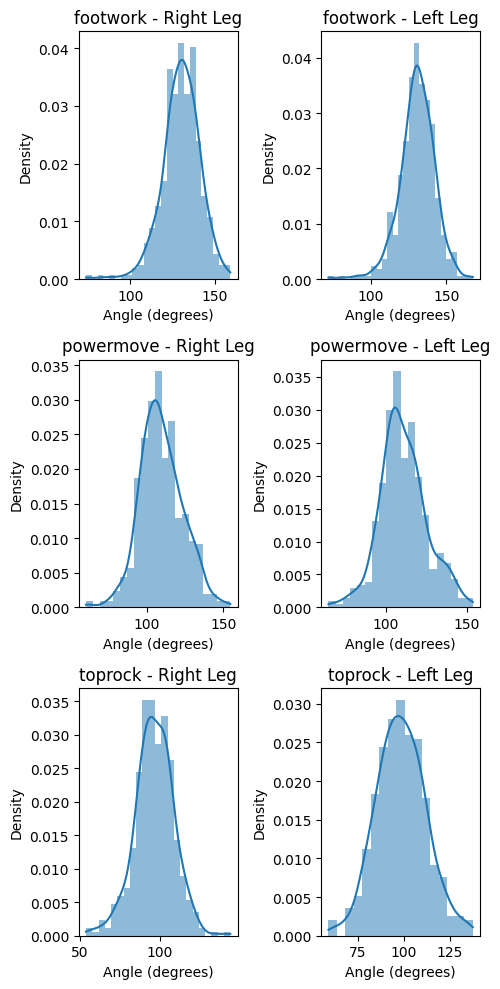

In [ ]:
class_angles_hka =extract_angles_from_dataset(flattened_clips, encoded_categories, right_keypoints, left_keypoints)
plot_hip_leg_angle(class_angles_hka, category_to_int)

In [ ]:
mean_angles = calculate_mean_angles(class_angles_hka)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Leg Angle: {mean_angles[label]['right']:.2f}, Mean Left Leg Angle: {mean_angles[label]['left']:.2f}")

Class toprock - Mean Right Leg Angle: 96.61, Mean Left Leg Angle: 98.48
Class powermove - Mean Right Leg Angle: 109.39, Mean Left Leg Angle: 110.93
Class footwork - Mean Right Leg Angle: 130.20, Mean Left Leg Angle: 130.64


Hip Knee horizontal line calculate if the hips are parallel or below the knee like then squatting.

In [ ]:
# Keypoint indices for right and left legs (hip, knee)
right_keypoints = [12, 14]  # right hip, right knee
left_keypoints = [11, 13]  # left hip, left knee

# Assuming 'data' is your padded_clips and 'labels' correspond to y_train
hrz_class_angles = extract_horizontal_angles_from_df(flattened_clips, encoded_categories, right_keypoints, left_keypoints)


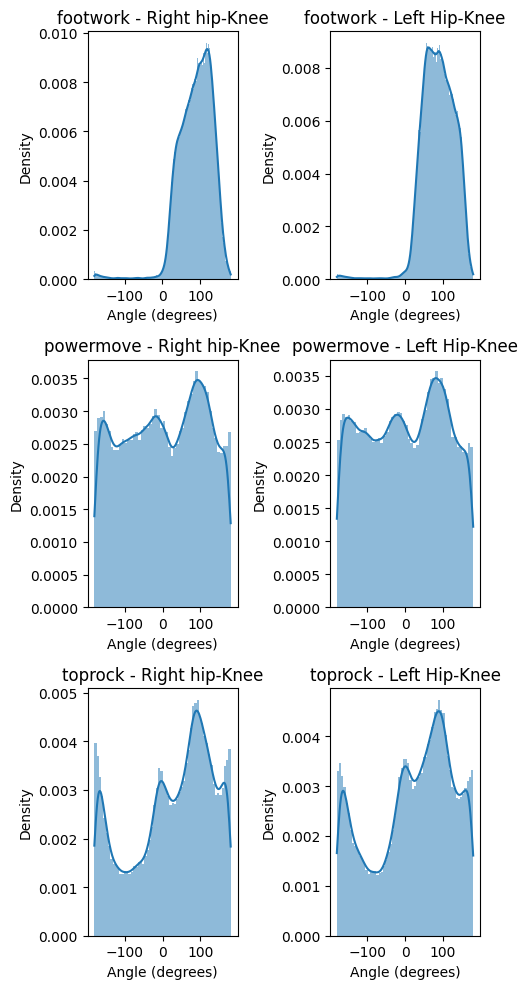

In [ ]:
plot_hip_knee_floor(hrz_class_angles, category_to_int)

In [ ]:
mean_horz_angles = calculate_mean_angles(hrz_class_angles)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_horz_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean Right Hip-Knee-Floor Angle: {mean_horz_angles[label]['right']:.2f}, Mean Hip-Knee-Floor Angle: {mean_horz_angles[label]['left']:.2f}")

Class toprock - Mean Right Hip-Knee-Floor Angle: 24.52, Mean Hip-Knee-Floor Angle: 21.24
Class powermove - Mean Right Hip-Knee-Floor Angle: 2.85, Mean Hip-Knee-Floor Angle: 1.01
Class footwork - Mean Right Hip-Knee-Floor Angle: 88.57, Mean Hip-Knee-Floor Angle: 88.14


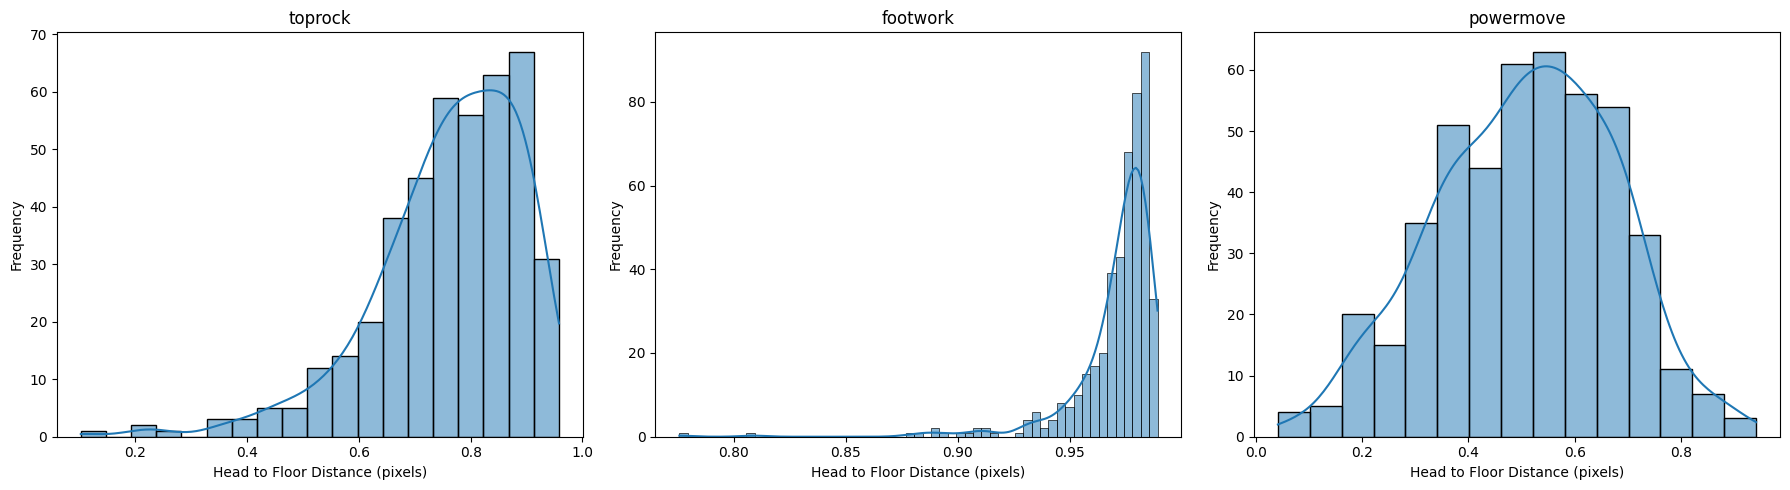

In [ ]:
head_to_floor_distances = extract_head_to_floor_distances(flattened_clips, encoded_categories, category_to_int)
plot_head_to_floor_histograms(head_to_floor_distances)

In [ ]:
head_dist= calculate_mean_distance(head_to_floor_distances)
head_dist

{'toprock': 0.7607817715982209,
 'footwork': 0.9708167567989453,
 'powermove': 0.5077703016672418}

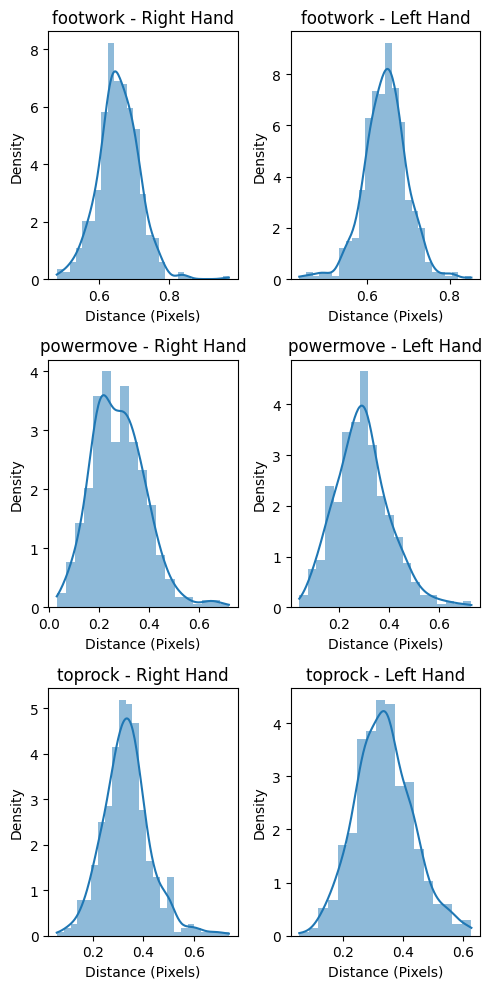

In [ ]:
hand_to_floor_distances = extract_hand_to_floor_distances(flattened_clips, encoded_categories)
plot_hand_distance_3x2_with_category_names(hand_to_floor_distances, category_to_int)

In [ ]:
mean_hand_angles = calculate_mean_hand_distance(hand_to_floor_distances)
int_to_category = {v: k for k, v in category_to_int.items()}
# Print mean angles for each class and each leg
for label in mean_hand_angles:
    category_name = int_to_category[label]
    print(f"Class {category_name} - Mean right wrist to floor distance: {mean_hand_angles[label]['right']:.2f}, Mean left wrist to floor distance: {mean_hand_angles[label]['left']:.2f}")

Class toprock - Mean right wrist to floor distance: 0.33, Mean left wrist to floor distance: 0.34
Class powermove - Mean right wrist to floor distance: 0.28, Mean left wrist to floor distance: 0.29
Class footwork - Mean right wrist to floor distance: 0.66, Mean left wrist to floor distance: 0.64


Calculate values for all clips and segments

In [ ]:
hip_knee_ankle_angles = []
for clip in flattened_clips:  # Assuming flattened_clips is defined elsewhere
    segment_hip = []
    for segment in clip:
        temp_hip = []
        # Extracting left and right side keypoints for hip, knee, and ankle
        left_hip = np.array([segment[11*2], segment[11*2 + 1]])
        left_knee = np.array([segment[13*2], segment[13*2 + 1]])
        left_ankle = np.array([segment[15*2], segment[15*2 + 1]])

        right_hip = np.array([segment[12*2], segment[12*2 + 1]])
        right_knee = np.array([segment[14*2], segment[14*2 + 1]])
        right_ankle = np.array([segment[16*2], segment[16*2 + 1]])

        # Calculate angles
        left_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_angle = calculate_angle(right_hip, right_knee, right_ankle)

        # Calculate horizontal angles
        left_hip_x, left_hip_y = segment[11*2], segment[11*2 + 1]
        left_knee_x, left_knee_y = segment[13*2], segment[13*2 + 1]
        left_hrz = calculate_angle_to_horizontal((left_hip_x, left_hip_y), (left_knee_x, left_knee_y))

        right_hip_x, right_hip_y = segment[12*2], segment[12*2 + 1]
        right_knee_x, right_knee_y = segment[14*2], segment[14*2 + 1]
        right_hrz = calculate_angle_to_horizontal((right_hip_x, right_hip_y), (right_knee_x, right_knee_y))

        # Calculate head to floor distance
        head_to_floor_distance = calculate_head_to_floor_distance(segment)

        #wrist values
        left_wrist_distance_to_floor = calculate_hand_to_floor_distance(segment, 9)
        right_wrist_distance_to_floor = calculate_hand_to_floor_distance(segment, 10)

        # Append calculated values to temp list
        temp_hip.append(left_angle)
        temp_hip.append(right_angle)
        temp_hip.append(left_hrz)
        temp_hip.append(right_hrz)
        temp_hip.append(head_to_floor_distance)
        temp_hip.append(left_wrist_distance_to_floor)
        temp_hip.append(right_wrist_distance_to_floor)
        segment_hip.append(temp_hip)
    hip_knee_ankle_angles.append(segment_hip)



LSTM model with padding to max lenght

In [ ]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='post', dtype='float32')
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels


In [ ]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='post', dtype='float32')
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_categorical, test_size=0.2, random_state=42)

# Model creation
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(None, 7)),  # Adjust based on your data's feature size
    LSTM(32),
    Dense(3, activation='softmax')  # Output layer for 3 categories
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

Epoch 1/10
34/34 [==============================] - 52s 1s/step - loss: 1.0995 - accuracy: 0.3265 - val_loss: 1.0966 - val_accuracy: 0.3616
Epoch 2/10
34/34 [==============================] - 60s 2s/step - loss: 1.0983 - accuracy: 0.3108 - val_loss: 1.0969 - val_accuracy: 0.3616
Epoch 3/10
34/34 [==============================] - 45s 1s/step - loss: 1.0980 - accuracy: 0.3404 - val_loss: 1.0968 - val_accuracy: 0.3616
Epoch 4/10
34/34 [==============================] - 48s 1s/step - loss: 1.0982 - accuracy: 0.3210 - val_loss: 1.0966 - val_accuracy: 0.3616
Epoch 5/10
34/34 [==============================] - 52s 2s/step - loss: 1.0981 - accuracy: 0.3367 - val_loss: 1.0968 - val_accuracy: 0.3616
Epoch 6/10
34/34 [==============================] - 42s 1s/step - loss: 1.0978 - accuracy: 0.3228 - val_loss: 1.0958 - val_accuracy: 0.3616
Epoch 7/10
34/34 [==============================] - 66s 2s/step - loss: 1.0975 - accuracy: 0.3404 - val_loss: 1.0967 - val_accuracy: 0.3616
Epoch 8/10
34/34 [==

Identify a sorted

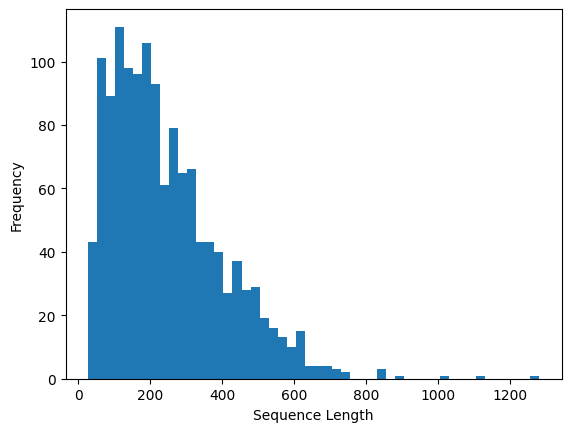

In [ ]:
sequence_lengths = [len(seq) for seq in hip_knee_ankle_angles]

plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Determine a suitable maxlen based on the distribution, for example, the 90th percentile
maxlen = np.percentile(sequence_lengths, 90)

CNN with drop out layers and reduced lenght padding

In [ ]:
data_padded = pad_sequences(hip_knee_ankle_angles, padding='pre', truncating='pre', maxlen=int(maxlen), dtype='float32') #use max lenght to 90 percentile and pretructating.
labels_categorical = to_categorical(encoded_categories)  # One-hot encode labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_padded, labels_categorical, test_size=0.2, random_state=42)

# Model creation
model = Sequential([
LSTM(128, return_sequences=True, input_shape=(None, 7)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Training
history =model.fit(X_train, y_train, epochs=8, validation_split=0.1)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, None, 128)         69632     
                                                                 
 dropout_10 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_16 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 119235 (465.76 KB)
Trainable params: 119235 (465.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/8
31/3

In [ ]:
# Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

9/9 [==============================] - 2s 251ms/step - loss: 0.4508 - accuracy: 0.8155
Test accuracy: 0.8154981732368469


9/9 [==============================] - 3s 249ms/step
              precision    recall  f1-score   support

           0       0.64      0.76      0.70        75
           1       0.82      0.71      0.77        98
           2       0.97      0.96      0.96        98

    accuracy                           0.82       271
   macro avg       0.81      0.81      0.81       271
weighted avg       0.83      0.82      0.82       271



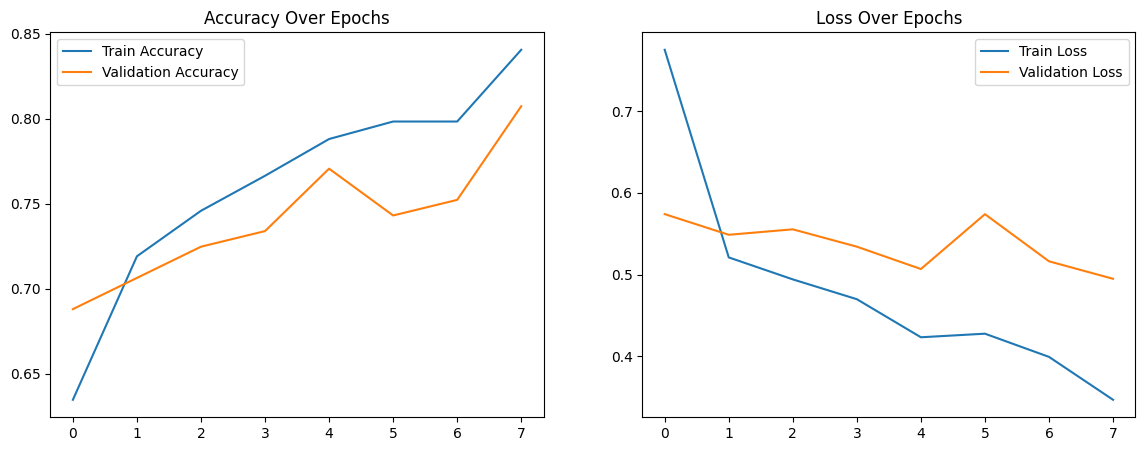

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes))

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)
# Plotting confusion matrix or use seaborn for a nicer plot

# Plotting training history
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.show()

In [ ]:
category_to_int

{'toprock': 0, 'powermove': 1, 'footwork': 2}